**GAN** se sastoji od **generatora** **i** **diskriminatora**. Nakon obuke, generator je robot  koji generiše fotografije pasa. Tokom treninga diskriminator uči generator kako da nacrta psa. (I obično G uči D-a da prikriva stvarne od lažnih pasa). Generator nikada ne vidi slike pasa. Umesto toga, kontinuirano pokušava da nacrta psa i trenira ga diskriminator.

Unzipovanje fotografija iz all-dogs.zip

In [ ]:
!unzip /content/drive/MyDrive/all-dogs.zip


Streaming output truncated to the last 5000 lines.
  inflating: all-dogs/n02113624_8890.jpg  
  inflating: all-dogs/n02107683_215.jpg  
  inflating: all-dogs/n02093428_5326.jpg  
  inflating: all-dogs/n02105412_8018.jpg  
  inflating: all-dogs/n02093647_3129.jpg  
  inflating: all-dogs/n02088466_8078.jpg  
  inflating: all-dogs/n02108915_4214.jpg  
  inflating: all-dogs/n02089078_2841.jpg  
  inflating: all-dogs/n02105855_3498.jpg  
  inflating: all-dogs/n02094114_2823.jpg  
  inflating: all-dogs/n02088094_649.jpg  
  inflating: all-dogs/n02091831_2232.jpg  
  inflating: all-dogs/n02096585_3105.jpg  
  inflating: all-dogs/n02109961_977.jpg  
  inflating: all-dogs/n02097047_5869.jpg  
  inflating: all-dogs/n02106030_16250.jpg  
  inflating: all-dogs/n02110958_13721.jpg  
  inflating: all-dogs/n02107142_8437.jpg  
  inflating: all-dogs/n02094433_1312.jpg  
  inflating: all-dogs/n02097474_5481.jpg  
  inflating: all-dogs/n02097130_1531.jpg  
  inflating: all-dogs/n02092339_284.jpg  
  inf

Unzipovanje anotacija:

In [ ]:
!unzip /content/drive/MyDrive/Annotation.zip

Streaming output truncated to the last 5000 lines.
  inflating: Annotation/n02088094-Afghan_hound/n02088094_5285  
  inflating: __MACOSX/Annotation/n02088094-Afghan_hound/._n02088094_5285  
  inflating: Annotation/n02088094-Afghan_hound/n02088094_4501  
  inflating: __MACOSX/Annotation/n02088094-Afghan_hound/._n02088094_4501  
  inflating: Annotation/n02088094-Afghan_hound/n02088094_13442  
  inflating: __MACOSX/Annotation/n02088094-Afghan_hound/._n02088094_13442  
  inflating: Annotation/n02088094-Afghan_hound/n02088094_8764  
  inflating: __MACOSX/Annotation/n02088094-Afghan_hound/._n02088094_8764  
  inflating: Annotation/n02088094-Afghan_hound/n02088094_3982  
  inflating: __MACOSX/Annotation/n02088094-Afghan_hound/._n02088094_3982  
  inflating: Annotation/n02088094-Afghan_hound/n02088094_3949  
  inflating: __MACOSX/Annotation/n02088094-Afghan_hound/._n02088094_3949  
  inflating: Annotation/n02088094-Afghan_hound/n02088094_1410  
  inflating: __MACOSX/Annotation/n02088094-Afghan

Ucitavanje i postavljanje fotografija na fiksnu veličinu, kao i sam prikaz istih:

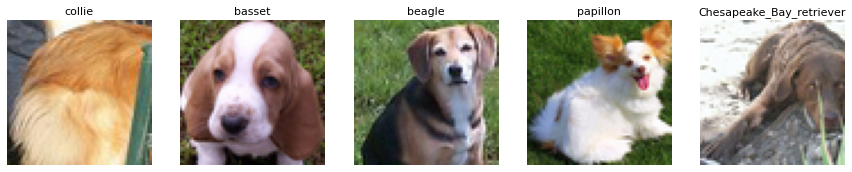

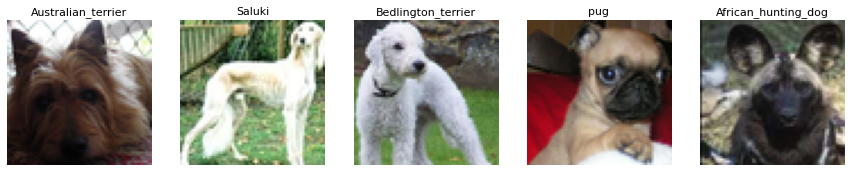

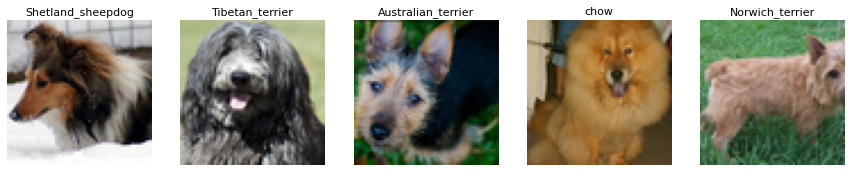

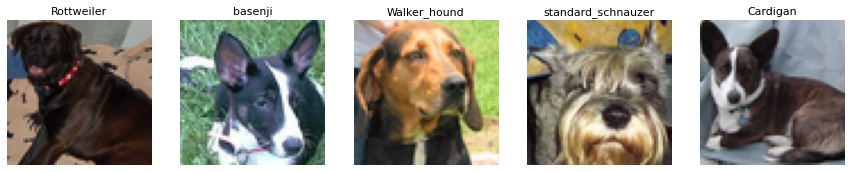

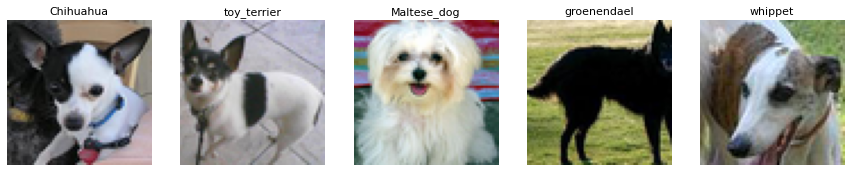

In [ ]:
ComputeLB = True
DogsOnly = True

import numpy as np, pandas as pd, os
import xml.etree.ElementTree as ET 
import matplotlib.pyplot as plt, zipfile 
from PIL import Image 

ROOT = '/content/input/'
if not ComputeLB: ROOT = '../content/'
IMAGES = os.listdir(ROOT + 'all-dogs/')
breeds = os.listdir(ROOT + 'Annotation/') 

idxIn = 0; namesIn = []
imagesIn = np.zeros((25000,64,64,3))

# CROP WITH BOUNDING BOXES TO GET DOGS ONLY
# https://www.kaggle.com/paulorzp/show-annotations-and-breeds
if DogsOnly:
    for breed in breeds:
        for dog in os.listdir(ROOT+'Annotation/'+breed):
            try: img = Image.open(ROOT+'all-dogs/'+dog+'.jpg') 
            except: continue           
            tree = ET.parse(ROOT+'Annotation/'+breed+'/'+dog)
            root = tree.getroot()
            objects = root.findall('object')
            for o in objects:
                bndbox = o.find('bndbox') 
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
                w = np.min((xmax - xmin, ymax - ymin))
                img2 = img.crop((xmin, ymin, xmin+w, ymin+w))
                img2 = img2.resize((64,64), Image.ANTIALIAS)
                imagesIn[idxIn,:,:,:] = np.asarray(img2)
                #if idxIn%1000==0: print(idxIn)
                namesIn.append(breed)
                idxIn += 1
    idx = np.arange(idxIn)
    np.random.shuffle(idx)
    imagesIn = imagesIn[idx,:,:,:]
    namesIn = np.array(namesIn)[idx]
    
# RANDOMLY CROP FULL IMAGES
else:
    x = np.random.choice(np.arange(20579),10000)
    for k in range(len(x)):
        img = Image.open(ROOT + 'all-dogs/' + IMAGES[x[k]])
        w = img.size[0]
        h = img.size[1]
        sz = np.min((w,h))
        a=0; b=0
        if w<h: b = (h-sz)//2
        else: a = (w-sz)//2
        img = img.crop((0+a, 0+b, sz+a, sz+b))  
        img = img.resize((64,64), Image.ANTIALIAS)   
        imagesIn[idxIn,:,:,:] = np.asarray(img)
        namesIn.append(IMAGES[x[k]])
        if idxIn%1000==0: print(idxIn)
        idxIn += 1
    
# DISPLAY CROPPED IMAGES
x = np.random.randint(0,idxIn,25)
for k in range(5):
    plt.figure(figsize=(15,3))
    for j in range(5):
        plt.subplot(1,5,j+1)
        img = Image.fromarray( imagesIn[x[k*5+j],:,:,:].astype('uint8') )
        plt.axis('off')
        if not DogsOnly: plt.title(namesIn[x[k*5+j]],fontsize=11)
        else: plt.title(namesIn[x[k*5+j]].split('-')[1],fontsize=11)
        plt.imshow(img)
    plt.show()

Importovnje neophodnih biblioteka:




In [ ]:
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Reshape, Flatten, concatenate, UpSampling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD, Adam

Kreiranje deskriminante:

In [ ]:
# BUILD DISCRIMINATIVE NETWORK
dog = Input((12288,))
dogName = Input((10000,))
x = Dense(12288, activation='sigmoid')(dogName) 
x = Reshape((2,12288,1))(concatenate([dog,x]))
x = Conv2D(1,(2,1),use_bias=False,name='conv')(x)
discriminated = Flatten()(x)

# COMPILE
discriminator = Model([dog,dogName], discriminated)
discriminator.get_layer('conv').trainable = False
discriminator.get_layer('conv').set_weights([np.array([[[[-1.0 ]]],[[[1.0]]]])])
discriminator.compile(optimizer='adam', loss='binary_crossentropy')

# DISPLAY ARCHITECTURE
discriminator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 10000)]      0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 12288)]      0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 12288)        122892288   input_2[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 24576)        0           input_1[0][0]                    
                                                                 dense[0][0]                  

Obučićemo Diskriminator da pamti slike sa treninga:

In [ ]:
# TRAINING DATA
train_y = (imagesIn[:10000,:,:,:]/255.).reshape((-1,12288))
train_X = np.zeros((10000,10000))
for i in range(10000): train_X[i,i] = 1
zeros = np.zeros((10000,12288))

# TRAIN NETWORK
lr = 0.5
for k in range(5):
    annealer = LearningRateScheduler(lambda x: lr)
    h = discriminator.fit([zeros,train_X], train_y, epochs = 10, batch_size=256, callbacks=[annealer], verbose=0)
    print('Epoch',(k+1)*10,'/30 - loss =',h.history['loss'][-1] )
    if h.history['loss'][-1]<0.533: lr = 0.1

Epoch 10 /30 - loss = 0.5517370104789734
Epoch 20 /30 - loss = 0.5341053009033203
Epoch 30 /30 - loss = 0.5321140885353088
Epoch 40 /30 - loss = 0.5319215059280396
Epoch 50 /30 - loss = 0.5318113565444946


Brisanje fotografija za trening:

In [ ]:
del train_X, train_y, imagesIn

Discriminator Recalls from Memory Dogs


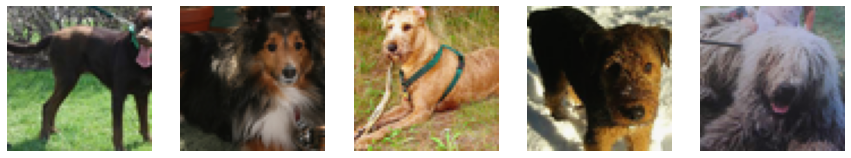

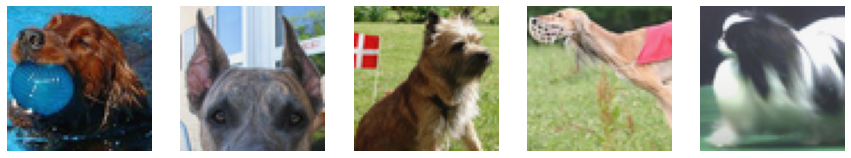

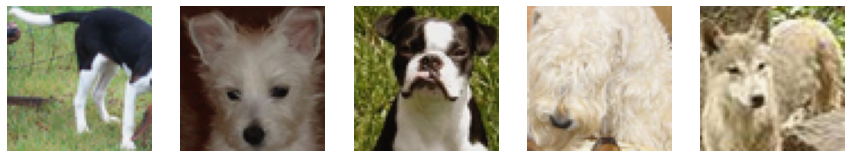

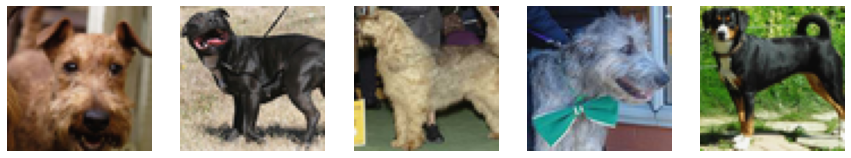

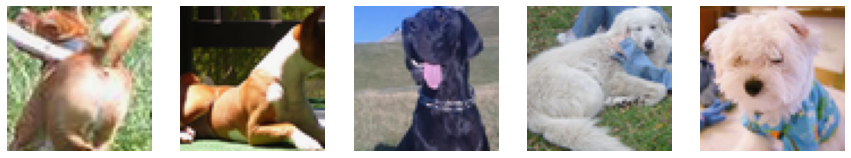

In [ ]:
print('Discriminator Recalls from Memory Dogs')    
for k in range(5):
    plt.figure(figsize=(15,3))
    for j in range(5):
        xx = np.zeros((10000))
        xx[np.random.randint(10000)] = 1
        plt.subplot(1,5,j+1)
        img = discriminator.predict([zeros[0,:].reshape((-1,12288)),xx.reshape((-1,10000))]).reshape((-1,64,64,3))
        img = Image.fromarray( (255*img).astype('uint8').reshape((64,64,3)))
        plt.axis('off')
        plt.imshow(img)
    plt.show()

Kreiranje Generator i GAN
Namerno ćemo našem generatoru dati usko grlo u njegovo sećanje. Korišćenje loše memorije primorava Generator da nauči uopštavanje slika i da ih ne pamti tačno.

In [ ]:
# BUILD GENERATOR NETWORK
BadMemory = True

if BadMemory:
    seed = Input((10000,))
    x = Dense(2048, activation='elu')(seed)
    x = Reshape((8,8,32))(x)
    x = Conv2D(128, (3, 3), activation='elu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='elu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(3, (3, 3), activation='linear', padding='same')(x)
    generated = Flatten()(x)
else:
    seed = Input((10000,))
    generated = Dense(12288, activation='linear')(seed)

# COMPILE
generator = Model(seed, [generated,Reshape((10000,))(seed)])

# DISPLAY ARCHITECTURE
generator.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 10000)]      0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 2048)         20482048    input_3[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 8, 8, 32)     0           dense_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 8, 8, 128)    36992       reshape_1[0][0]                  
____________________________________________________________________________________________

In [ ]:
# BUILD GENERATIVE ADVERSARIAL NETWORK
discriminator.trainable=False    
gan_input = Input(shape=(10000,))
x = generator(gan_input)
gan_output = discriminator(x)

# COMPILE GAN
gan = Model(gan_input, gan_output)
gan.compile(optimizer=Adam(5), loss='mean_squared_error')

# DISPLAY ARCHITECTURE
gan.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 10000)]      0                                            
__________________________________________________________________________________________________
model_1 (Functional)            [(None, 12288), (Non 20612163    input_7[0][0]                    
__________________________________________________________________________________________________
model (Functional)              (None, 12288)        122892290   model_1[3][0]                    
                                                                 model_1[3][1]                    
Total params: 143,504,453
Trainable params: 20,612,163
Non-trainable params: 122,892,290
__________________________________________________________________________________________________


Discriminator uči Generator
U tipičnom GAN-u, diskriminator prethodno ne pamti slike treninga. 
Umesto toga, on uči da razlikuje stvarne slike od lažnih slika istovremeno kada i generator uči da pravi lažne.U ovom GAN-u naučili smo Diskriminator pre vremena i on će sada naučiti Generatora.

Epoch 1 /9 - loss = 0.25069716572761536


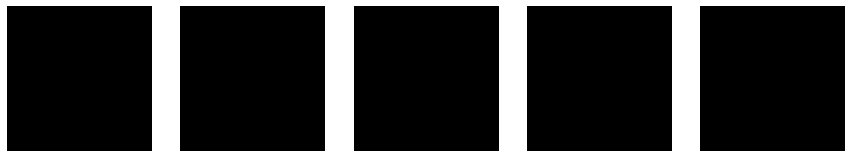

Epoch 2 /9 - loss = 0.25069713592529297


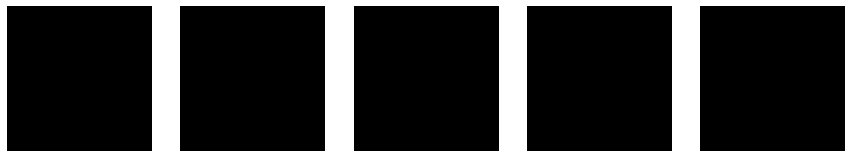

Epoch 3 /9 - loss = 0.2506971061229706


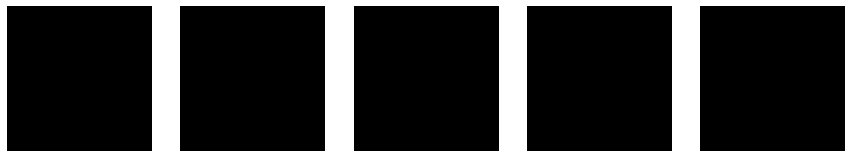

Epoch 4 /9 - loss = 0.25069713592529297


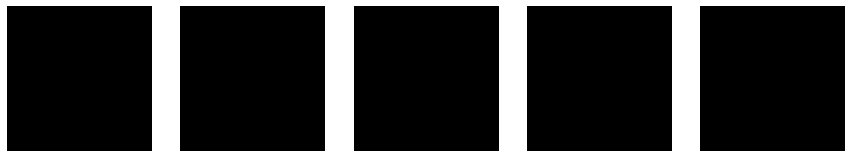

Epoch 5 /9 - loss = 0.25069713592529297


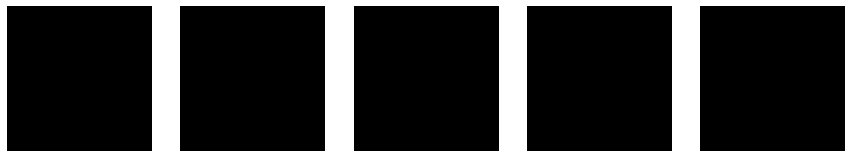

Epoch 6 /9 - loss = 0.2506971061229706


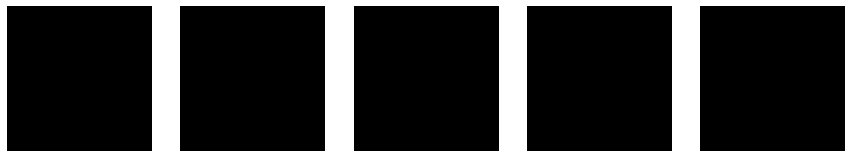

Epoch 7 /9 - loss = 0.25069713592529297


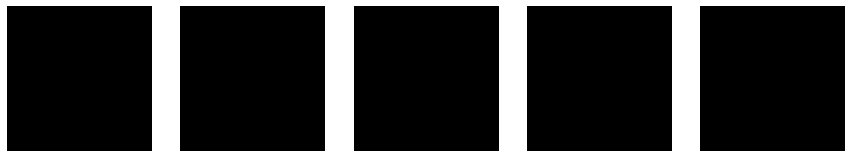

In [ ]:
# TRAINING DATA
train = np.zeros((10000,10000))
for i in range(10000): train[i,i] = 1
zeros = np.zeros((10000,12288))

# TRAIN NETWORKS
ep = 1; it = 9
if BadMemory: lr = 0.005
else: lr = 5.
    
for k in range(it):  

    # BEGIN DISCRIMINATOR COACHES GENERATOR
    annealer = LearningRateScheduler(lambda x: lr)
    h = gan.fit(train, zeros, epochs = ep, batch_size=256, callbacks=[annealer], verbose=0)

    # DISPLAY GENERATOR LEARNING PROGRESS 
    print('Epoch',(k+1),'/'+str(it)+' - loss =',h.history['loss'][-1] )
    plt.figure(figsize=(15,3))
    for j in range(5):
        xx = np.zeros((10000))
        xx[np.random.randint(10000)] = 1
        plt.subplot(1,5,j+1)
        img = generator.predict(xx.reshape((-1,10000)))[0].reshape((-1,64,64,3))
        img = Image.fromarray( (img).astype('uint8').reshape((64,64,3)))
        plt.axis('off')
        plt.imshow(img)
    plt.show()  
            
    # ADJUST LEARNING RATES
    if BadMemory:
        ep *= 2
        if ep>=32: lr = 0.001
        if ep>256: ep = 256
    else:
        if h.history['loss'][-1] < 25: lr = 1.
        if h.history['loss'][-1] < 1.5: lr = 0.5

Build Generator Class
Naša generativna mreža je sada naučila sve slike sa treninga iz naših diskriminativnih mreža. Sa svojim lošim pamćenjem, nadamo se da je naučio da donekle generališe. Sada gradimo Generatorsku klasu koja prihvata bilo koji slučaj 100-dimenzionalnih vektora i daje sliku. Naša klasa će vratiti 70% jedne „memorisane“ slike pomešane sa 30% druge. Budući da su slike uskladištene u konvolucionoj mreži, nadamo se da ona generiše konceptualnu mešavinu (nasuprot mešavini piksela).

In [ ]:
class DogGenerator:
    index = 0   
    def getDog(self,seed):
        xx = np.zeros((10000))
        xx[self.index] = 0.70
        xx[np.random.randint(10000)] = 0.30
        img = generator.predict(xx.reshape((-1,10000)))[0].reshape((64,64,3))
        self.index = (self.index+1)%10000
        return Image.fromarray( img.astype('uint8') ) 

Primeri generisanih pasa:

In [ ]:
# DISPLAY EXAMPLE DOGS
d = DogGenerator()
for k in range(3):
    plt.figure(figsize=(15,3))
    for j in range(5):
        plt.subplot(1,5,j+1)
        img = d.getDog(np.random.normal(0,1,100))
        plt.axis('off')
        plt.imshow(img)
    plt.show() 

NameError: ignored

In [ ]:
# SAVE TO ZIP FILE NAMED IMAGES.ZIP
z = zipfile.PyZipFile('images.zip', mode='w')
d = DogGenerator()
for k in range(10000):
    img = d.getDog(np.random.normal(0,1,100))
    f = str(k)+'.png'
    img.save(f,'PNG'); z.write(f); os.remove(f)
    #if k % 1000==0: print(k)
z.close()